# 实现和测试2层 eBNN MLP

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

%matplotlib inline

# 导入自己实现的eBNN层
from ebnn_layers import BinaryDenseBN

# 导入自己实现的eBNN层的NumPy实现
from ebnn_numpy import (
    binarize_fully_connected_inference,
    batch_normalization_inference,
    softmax_inference,
    max_softmax_inference,
)
from ebnn_ops import binarize_np
import utils

np.random.seed(72)  # 设置随机种子，使得结果更可复现
print(tf.version.VERSION)

2.10.0


# 定义超参数

In [2]:
# hyper parameters

# train
batch_size = 128
epochs = 10
# learning rate
lr_start = 1e-4
# BN
epsilon = 1e-5
momentum = 0.99
# structure
is_use_bias = True
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_start)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# 预处理 MNIST 数据集

Training set images shape:  (48000, 28, 28)
Training set labels shape:  (48000,)
Test set size:  10000
Validation set size:  12000


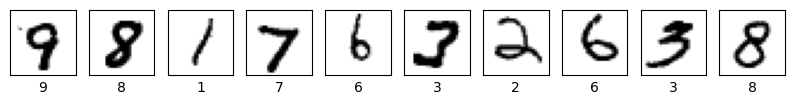

In [3]:
# 导入 MNIST 数据集
(train_images, train_labels), (
    test_images,
    test_labels,
) = tf.keras.datasets.mnist.load_data()

class_names = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

# 打乱训练集
indices = np.arange(len(train_images))
np.random.shuffle(indices)
train_images = train_images[indices]
train_labels = train_labels[indices]

# 划分20%验证集，并将剩余部分作为新的训练集
num_val_samples = int(len(train_images) * 0.2)
val_images = train_images[:num_val_samples]
val_labels = train_labels[:num_val_samples]
train_images = train_images[num_val_samples:]
train_labels = train_labels[num_val_samples:]

# 输出数据集信息
print("Training set images shape: ", train_images.shape)
print("Training set labels shape: ", train_labels.shape)
print("Test set size: ", test_labels.shape[0])
print("Validation set size: ", val_labels.shape[0])

# 显示前十个图像
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap="binary")
    plt.xlabel(train_labels[i].item())
plt.show()

In [4]:
# 数据预处理
# 将数组中元素的数据类型转换为 float32
train_images = train_images.astype("float32")
test_images = test_images.astype("float32")
val_images = val_images.astype("float32")

# 没有做归一化处理，减少单片机需要保存的大小
# 归一化: 将数据转换到 [0, 1] 的范围内
# train_images, test_images, val_images = (
#     train_images / 255.0,
#     test_images / 255.0,
#     val_images / 255.0,
# )

# 模型构建 (2层全连接层)

In [5]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28, 28, 1)))
model.add(BinaryDenseBN(units=16, use_bias=is_use_bias, is_binarized_activation=False))
model.add(BinaryDenseBN(units=10, use_bias=is_use_bias))

# 模型编译

In [6]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_start),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
# Display the model's architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 binary_dense_bn (BinaryDens  (None, 16)               12624     
 eBN)                                                            
                                                                 
 binary_dense_bn_1 (BinaryDe  (None, 10)               210       
 nseBN)                                                          
                                                                 
Total params: 12,834
Trainable params: 12,782
Non-trainable params: 52
_________________________________________________________________


In [7]:
# 创建绘图目录
plts_dir = Path("./plts")
plts_dir.mkdir(parents=True, exist_ok=True)

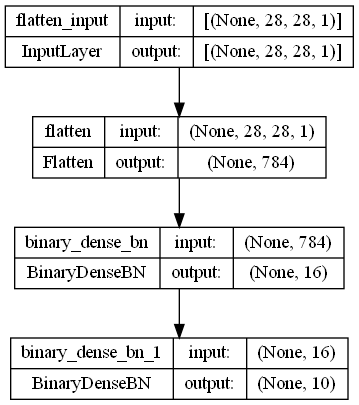

In [8]:
# 绘制模型结构图(将模型绘制为层计算图)
tf.keras.utils.plot_model(
    model, plts_dir / "eBNN_MLP_MNIST_Diagram.png", show_shapes=True
)

# 模型训练

In [9]:
# 配置 TensorBoard 日志回调
# board_bnn_callback = tf.keras.callbacks.TensorBoard(
#     log_dir=utils.get_tensorboard_dir(Path("./logs/bnn/mlp_mnist"), is_clear_out=True),
#     histogram_freq=1,
#     write_graph=True,
#     write_images=True,
#     profile_batch='10, 15',
# )

# 早停 Early Stopping 回调
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor="val_loss",
#     min_delta=0.001,
#     patience=5,
#     verbose=1,
#     mode="min",
#     restore_best_weights=True,
# )

In [10]:
history = model.fit(
    x=train_images,
    y=train_labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(val_images, val_labels),
    verbose=1,
    # callbacks=[board_bnn_callback, early_stopping],
)
history = history.history

Epoch 1/10
375/375 [==============================] - 5s 6ms/step - loss: 1.7731 - accuracy: 0.4145 - val_loss: 1.3589 - val_accuracy: 0.5973
Epoch 2/10
375/375 [==============================] - 2s 6ms/step - loss: 1.2006 - accuracy: 0.6910 - val_loss: 1.0694 - val_accuracy: 0.7436
Epoch 3/10
375/375 [==============================] - 2s 6ms/step - loss: 1.0424 - accuracy: 0.7584 - val_loss: 0.9628 - val_accuracy: 0.7852
Epoch 4/10
375/375 [==============================] - 2s 5ms/step - loss: 0.9542 - accuracy: 0.7855 - val_loss: 0.8934 - val_accuracy: 0.8069
Epoch 5/10
375/375 [==============================] - 2s 6ms/step - loss: 0.8869 - accuracy: 0.8049 - val_loss: 0.8288 - val_accuracy: 0.8236
Epoch 6/10
375/375 [==============================] - 2s 6ms/step - loss: 0.8355 - accuracy: 0.8140 - val_loss: 0.7972 - val_accuracy: 0.8342
Epoch 7/10
375/375 [==============================] - 2s 6ms/step - loss: 0.7994 - accuracy: 0.8209 - val_loss: 0.7678 - val_accuracy: 0.8300
Epoch 

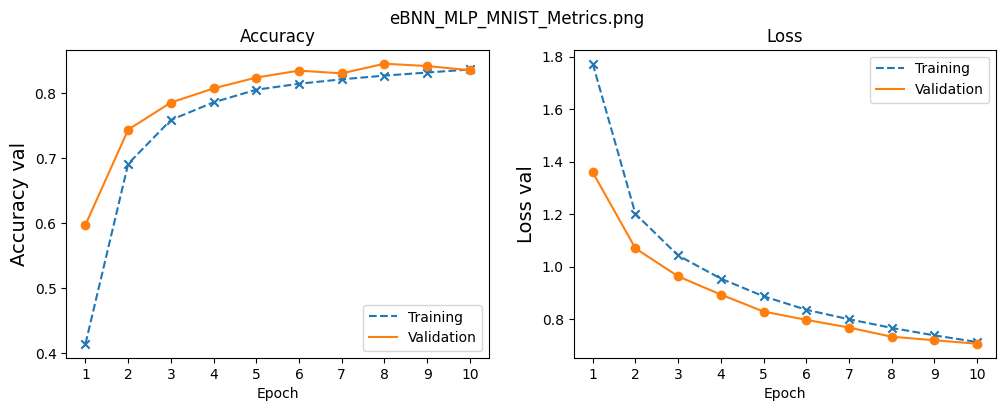

In [11]:
# 绘制训练和验证的损失和准确率图
utils.plt_training_validation_metrics(history, epochs, "eBNN_MLP_MNIST_Metrics.png")
plt.savefig(plts_dir / "eBNN_MLP_MNIST_Confusion", dpi=600)
plt.show()

# 模型评估

In [12]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print("Test loss:", test_loss)
print("Test top-1 accuracy:", test_acc)

313/313 - 1s - loss: 0.6965 - accuracy: 0.8375 - 736ms/epoch - 2ms/step
Test loss: 0.6964609026908875
Test top-1 accuracy: 0.8374999761581421


In [13]:
# 附加一个 Softmax 层，将logits转换为更容易理解的概率
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
# 使用BNN模型对完整测试集进行预测
predictions = probability_model.predict(test_images)
# 将预测结果转换为类别标签
predicted_labels = np.argmax(predictions, axis=1)

313/313 [==============================] - 1s 2ms/step


<Figure size 1000x1000 with 0 Axes>

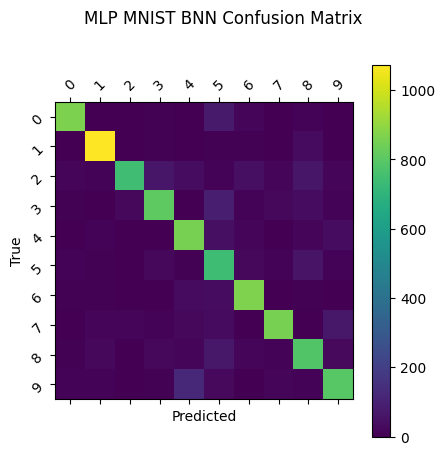

In [14]:
# 绘制混淆矩阵
confusion_mtx = tf.math.confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(10, 10))
plt.matshow(confusion_mtx, cmap="viridis")
plt.suptitle("MLP MNIST BNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.yticks(range(len(class_names)), class_names, rotation=45)
plt.colorbar()
plt.savefig(plts_dir / "eBNN_MLP_MNIST_Confusion", dpi=600)
plt.show()

# eBNN MLP 的 NumPy 实现

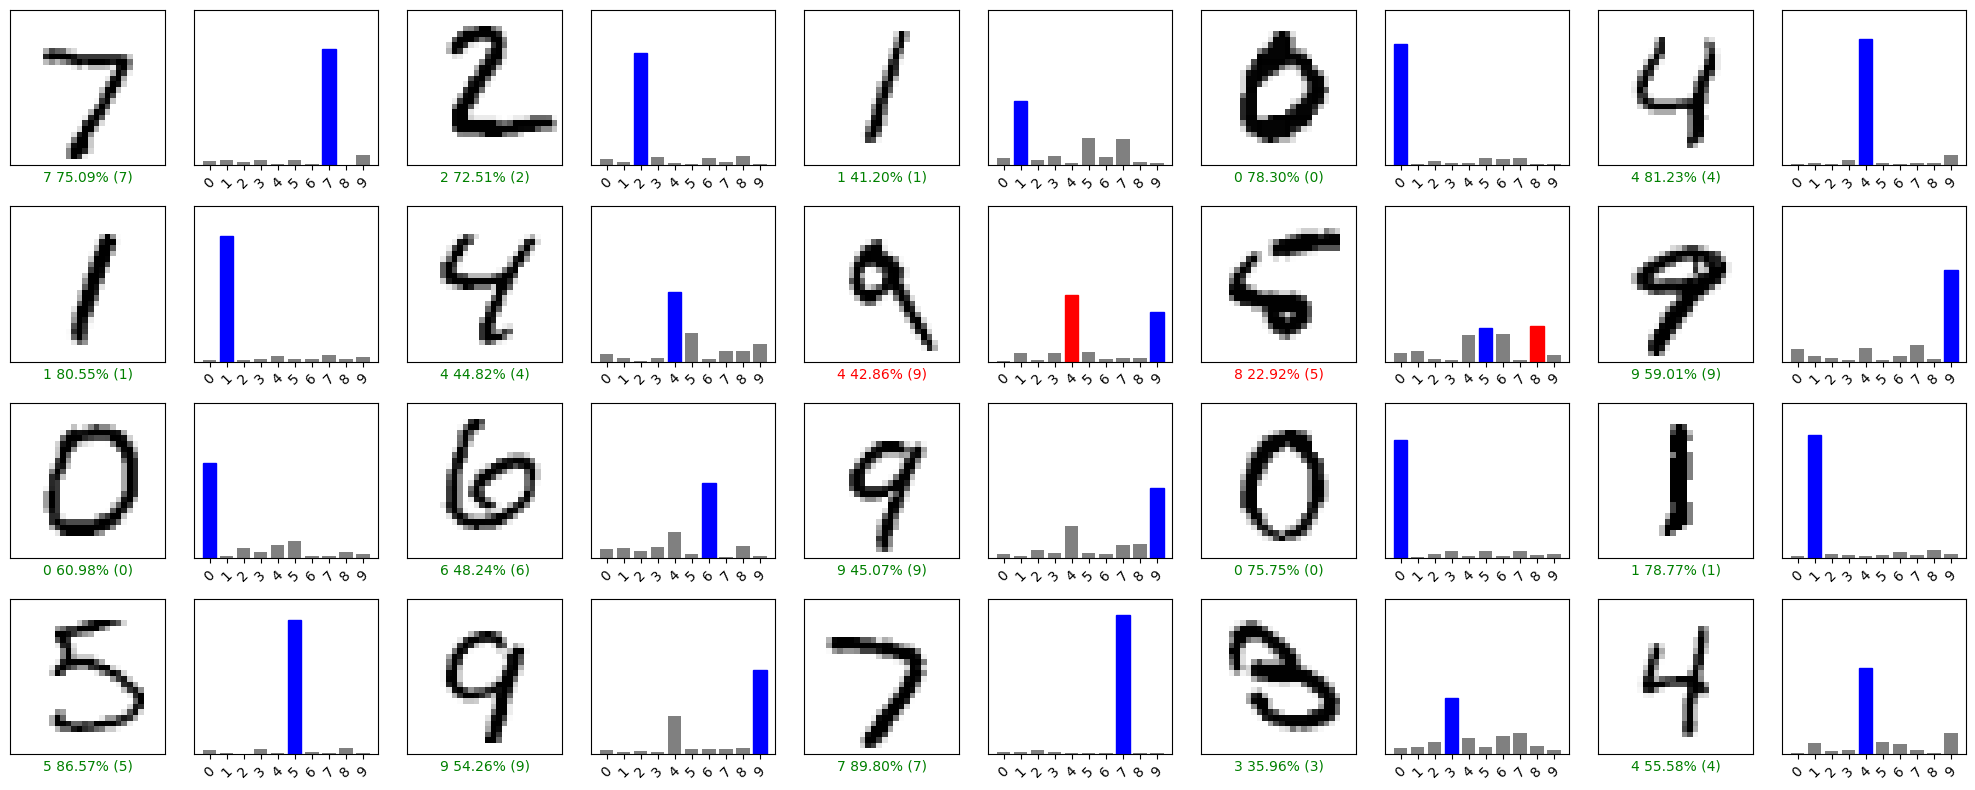

In [15]:
# 从 test_labels 中选取前20个样本进行预测
plt_rows = 4
plt_cols = 5
plt_images = plt_rows * plt_cols
# random_indices_plt = np.random.choice(test_labels.shape[0], plt_images, replace=False)
random_indices_plt = range(plt_images)
plt.figure(figsize=(2 * 2 * plt_cols, 2 * plt_rows))
for i in range(plt_images):
    idx_plt = random_indices_plt[i]
    plt.subplot(plt_rows, 2 * plt_cols, 2 * i + 1)
    utils.plt_predict_image(
        idx_plt, predictions, test_labels, class_names, test_images, cmap="binary"
    )
    plt.subplot(plt_rows, 2 * plt_cols, 2 * i + 2)
    utils.plt_predict_value_array(idx_plt, predictions, test_labels, class_names)
plt.tight_layout()
plt.savefig(plts_dir / "eBNN_MLP_MNIST_Result", dpi=600)
plt.show()

In [16]:
ebnn_test_batch_size = plt_images
test_loss, test_acc = model.evaluate(
    test_images[:ebnn_test_batch_size], test_labels[:ebnn_test_batch_size], verbose=2
)
print(f"Test {ebnn_test_batch_size} loss:", test_loss)
print(f"Test {ebnn_test_batch_size} top-1 accuracy:", test_acc)

1/1 - 0s - loss: 0.5596 - accuracy: 0.9000 - 20ms/epoch - 20ms/step
Test 20 loss: 0.5595970749855042
Test 20 top-1 accuracy: 0.8999999761581421


In [17]:
# 展平并reshape输入数据
X_flat = test_images[:ebnn_test_batch_size].reshape(ebnn_test_batch_size, -1)

# 第1层全连接层
if is_use_bias:
    fc_output_1 = binarize_fully_connected_inference(
        X_flat,
        model.layers[1].bdense.kernel.numpy(),
        model.layers[1].bdense.bias.numpy(),
    )
else:
    fc_output_1 = binarize_fully_connected_inference(
        X_flat, model.layers[1].bdense.kernel.numpy()
    )
# 批量归一化层
bn_output_1 = batch_normalization_inference(
    fc_output_1,
    model.layers[1].bn.gamma.numpy(),
    model.layers[1].bn.beta.numpy(),
    model.layers[1].bn.moving_mean.numpy(),
    model.layers[1].bn.moving_variance.numpy(),
    epsilon,
)

# 二值化激活值
binarized_activation_2 = binarize_np(bn_output_1)

# 第2层全连接层
if is_use_bias:
    fc_output_2 = binarize_fully_connected_inference(
        binarized_activation_2,
        model.layers[2].bdense.kernel.numpy(),
        model.layers[2].bdense.bias.numpy(),
    )
else:
    fc_output_2 = binarize_fully_connected_inference(
        binarized_activation_2, model.layers[2].bdense.kernel.numpy()
    )
# 批量归一化层
bn_output_2 = batch_normalization_inference(
    fc_output_2,
    model.layers[2].bn.gamma.numpy(),
    model.layers[2].bn.beta.numpy(),
    model.layers[2].bn.moving_mean.numpy(),
    model.layers[2].bn.moving_variance.numpy(),
    epsilon,
)

# Softmax层
probabilities = softmax_inference(bn_output_2)
# 输出概率最高的类别
predictions = max_softmax_inference(probabilities)

In [18]:
# 输出准确率信息
accuracy = np.sum(predictions == test_labels[:ebnn_test_batch_size]) / len(
    test_labels[:ebnn_test_batch_size]
)

print("Predictions:", predictions)
print("Correct:    ", test_labels[:ebnn_test_batch_size])
print("Accuracy:   ", accuracy)

Predictions: [7 2 1 0 4 1 4 4 8 9 0 6 9 0 1 5 9 7 3 4]
Correct:     [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
Accuracy:    0.9


# generate c

In [19]:
# 生成C语言代码至文件
with open("mlp_ebnn_data.h", "w", encoding="utf-8") as file:
    file.write(model.layers[1].generate_c("binarize_fc1") + "\n\n")
    file.write(model.layers[2].generate_c("binarize_fc2") + "\n")

In [20]:
print(model.layers[1].generate_c("binarize_fc1"))

int8_t binarize_fc1_w[12544] = {-1,-1,1,-1,1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,1,-1,1,-1,1,-1,-1,-1,1,-1,1,-1,-1,-1,-1,1,-1,1,-1,1,1,1,1,-1,1,1,1,-1,1,1,1,-1,1,-1,1,1,1,-1,1,1,-1,1,1,-1,1,1,-1,1,1,-1,1,1,1,1,-1,1,-1,-1,-1,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,1,-1,1,1,1,1,-1,1,1,1,1,1,-1,-1,-1,-1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,1,-1,1,-1,-1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,-1,-1,-1,1,1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,1,-1,-1,1,1,-1,-1,1,1,1,1,1,1,-1,-1,1,1,1,1,-1,1,1,1,1,-1,-1,1,1,-1,1,1,1,1,-1,1,1,1,1,-1,-1,1,1,-1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,1,1,1,-1,1,1,1,1,-1,-1,-1,1,1,-1,1,1,1,-1,1,-1,1,1,1,1,-1,-1,-1,1,1,1,-1,1,-1,1,1,-1,1,1,1,1,1,-1,1,-1,1,-1,1,1,-1,-1,-1,1,-1,-1,1,-1,-1,1,-1,-1,1,1,-1,1,-1,1,-1,-1,1,1,-1,-1,1,1,-1,1,-1,-1,1,1,1,1,-1,-1,-1,-1,1,1,-1,1,-1,1,-1,1,1,-1,-1,1,1,-1,-1,1,-1,-1,-1,1,-1,-1,1,1,1,-1,-1,1,1,-1,1,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,1,1,1,-1,-1,-1,1,1,1,-1,1,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,1,1,1,1,1,1,1,1,1,-1,-1,-1,-1,1,-1,1

In [21]:
print(model.layers[2].generate_c("binarize_fc2"))

int8_t binarize_fc2_w[160] = {1,-1,-1,1,1,1,-1,1,-1,-1,1,-1,-1,1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,1,-1,1,1,1,-1,1,-1,1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,-1,1,-1,1,-1,1,1,1,-1,-1,1,-1,-1,-1,1,-1,1,1,-1,-1,1,1,1,-1,1,1,1,-1,-1,1,-1,1,-1,-1,-1,1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,1,-1,-1,-1,1,-1,1,-1,1,1,1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,1,1,1,1,-1,-1,-1,1,1,1,-1,1,1,-1,1,1,-1,1,-1,1,-1,1,1,-1,1,1,-1,1,-1,-1,1,1,1,1,-1,1,1,-1,-1};
float binarize_fc2_b[10] = {-0.000008f,0.000016f,0.000048f,0.000018f,0.000060f,0.000066f,0.000017f,-0.000028f,-0.000026f,0.000038f};
float binarize_fc2_bn_gamma[10] = {1.319173f,1.310567f,1.300847f,1.302956f,1.306666f,1.263760f,1.296041f,1.292671f,1.268023f,1.278945f};
float binarize_fc2_bn_beta[10] = {-0.067883f,0.041516f,0.069939f,-0.004536f,-0.049006f,-0.018309f,-0.027017f,0.008296f,0.029059f,0.006590f};
float binarize_fc2_bn_mean[10] = {0.755307f,0.378327f,0.221808f,0.143178f,0.761968f,-0.027193f,0.484484f,-0.025356f,-0.088346f,0.005780f};
float binarize_fc2_bn_